## Project outline

### Data wrangling:

1. Gathering data 
2. Assessing data
3. Cleaning data
4. Storing, analyzing, and visualizing your wrangled data
5. Conclusions

## Gathering data
### 1. Load 'The WeRateDogs Twitter archive' 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive_enhanced.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 2. Download the 'The tweet image predictions' 
The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. 

In [3]:
import requests

# using requests to download data 
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
download = requests.get(url)
download

<Response [200]>

In [4]:
# get content type 
download.headers.get('content-type')

'text/tab-separated-values; charset=utf-8'

In [5]:
import io

# convert downloaded data from tsv to pandas DataFrame
tweet_image_pred = pd.read_csv(io.StringIO(download.content.decode('utf-8')),sep = '\t')
tweet_image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 3. Query the Twitter API for each tweet's JSON data using Python's Tweepy library
Extract tweets by tweet ID using api.user_timeline. Read each tweet and save data into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. 

In [25]:
import tweepy

# connect to twitter
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth)
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [8]:
tweet_ID = pd.merge(twitter_archive_enhanced,tweet_image_pred, how = 'outer',on = 'tweet_id').tweet_id
tweet_ID.shape

(2356,)

In [26]:
# read tweets 
all_tweets = []
error_id = []
for id_of_tweet in tweet_ID:
    try:
        tweet = api.get_status(id_of_tweet)
        all_tweets.append(tweet)
    except:
        error_id.append(id_of_tweet)

Rate limit reached. Sleeping for: 735
Rate limit reached. Sleeping for: 734


In [28]:
len(error_id)

25

In [29]:
# save data as 'tweet_json.txt'
with open('tweet_json.txt', 'w') as f:
    f.writelines("%s\n" % line for line in all_tweets)

In [30]:
# generate Dataframe
dftweets = [[tweet.id_str, 
              tweet.created_at, 
              tweet.favorite_count, 
              tweet.retweet_count, 
              tweet.text.encode("utf-8").decode("utf-8")] 
             for idx,tweet in enumerate(all_tweets)]
tweets_api = pd.DataFrame(dftweets,columns=["id","created_at","favorite_count","retweet_count", "text"])
tweets_api.to_csv('dog_rates_tweets.csv',index=False)
tweets_api.head()

,id,created_at,favorite_count,retweet_count,text
0,892420643555336193,2017-08-01 16:23:56,34735,7266,This is Phineas. He's a mystical boy. Only eve...
1,892177421306343426,2017-08-01 00:17:27,30096,5436,This is Tilly. She's just checking pup on you....
2,891815181378084864,2017-07-31 00:18:03,22650,3584,This is Archie. He is a rare Norwegian Pouncin...
3,891689557279858688,2017-07-30 15:58:51,38011,7468,This is Darla. She commenced a snooze mid meal...
4,891327558926688256,2017-07-29 16:00:24,36289,8021,This is Franklin. He would like you to stop ca...


In [6]:
# load csv data 
tweet_api = pd.read_csv('dog_rates_tweets.csv')
tweet_api.head()

,id,created_at,favorite_count,retweet_count,text
0,892420643555336193,2017-08-01 16:23:56,34735,7266,This is Phineas. He's a mystical boy. Only eve...
1,892177421306343426,2017-08-01 00:17:27,30096,5436,This is Tilly. She's just checking pup on you....
2,891815181378084864,2017-07-31 00:18:03,22650,3584,This is Archie. He is a rare Norwegian Pouncin...
3,891689557279858688,2017-07-30 15:58:51,38011,7468,This is Darla. She commenced a snooze mid meal...
4,891327558926688256,2017-07-29 16:00:24,36289,8021,This is Franklin. He would like you to stop ca...


## Accessing data

### 1. Visual accessment

In [7]:
twitter_archive_enhanced

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


#### Issue with twitter_archive_enhanced:
1. Some dogs have abnormal names like a, an, the, such, quite and etc. 
2. Rating_denominator is not alway 10. 
3. Some are retweets which we don't want. 
4. Some columns are not useful for analysis: source, in_reply_to_ , retweeted_ , expanded_urls, and etc.
5. Dog stages should be merged into one column. 

In [8]:
tweet_image_pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


#### Issue with tweet_image_pred:
1. jpg_url and img_num are not useful for the analysis.
2. This dataframe can be merged with twitter_archive_enhanced into a dataframe contains dog information of the tweet. 

In [9]:
tweet_api

,id,created_at,favorite_count,retweet_count,text
0,892420643555336193,2017-08-01 16:23:56,34735,7266,This is Phineas. He's a mystical boy. Only eve...
1,892177421306343426,2017-08-01 00:17:27,30096,5436,This is Tilly. She's just checking pup on you....
2,891815181378084864,2017-07-31 00:18:03,22650,3584,This is Archie. He is a rare Norwegian Pouncin...
3,891689557279858688,2017-07-30 15:58:51,38011,7468,This is Darla. She commenced a snooze mid meal...
4,891327558926688256,2017-07-29 16:00:24,36289,8021,This is Franklin. He would like you to stop ca...
5,891087950875897856,2017-07-29 00:08:17,18298,2690,Here we have a majestic great white breaching ...
6,890971913173991426,2017-07-28 16:27:12,10662,1734,Meet Jax. He enjoys ice cream so much he gets ...
7,890729181411237888,2017-07-28 00:22:40,58504,16328,When you watch your owner call another dog a g...
8,890609185150312448,2017-07-27 16:25:51,25208,3733,This is Zoey. She doesn't want to be one of th...
9,890240255349198849,2017-07-26 15:59:51,28734,6302,This is Cassie. She is a college pup. Studying...


#### Issue with tweets_api:
1. Some tweets are retweets.
2. Column name 'id' should be 'tweet_id'.

### 2. Programmatically  accessment

In [10]:
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### issue:
1. the number of in_reply_to_status_id and retweeted_status_id are above 0, indicates there are retweets. 
2. Timestamp should be changed to date-time.

In [11]:
twitter_archive_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


#### issue:
1. Rating_numerator is 0 or 1776?
2. Rating_denominator is 0 or 170?

In [12]:
tweet_image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### issue:
1. There are 2075 images predicted but 2356 tweets in twitter_archive_enhanced.

In [13]:
tweet_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
id                2331 non-null int64
created_at        2331 non-null object
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
text              2331 non-null object
dtypes: int64(3), object(2)
memory usage: 91.1+ KB


In [16]:
tweet_api.duplicated().sum()

0

### Summary of accessment

### quality issues:
1. Some dogs have abnormal names like a, an, the, such, quite and etc.
2. Missing names should be NaN instead of string 'None'.
3. Rating denominator is not always 10. 
4. Rating numerator is not accurate. 
5. Retweets need to be removed.
6. Dog stages are not accurate.
7. There are 2075 images predicted but 2356 tweets in twitter_archive_enhanced. 
8. Dog stages columns should be of boolean format.
9. datatype of tweet_id is int,it should be str
10. Timestamp should be date-time format.
11. Some tweets are not rating dogs.

### tidiness issues:
1. Dog stages should be one column. 
2. Unnecessary columns which is not useful for analysis. 
3. All three pieces of data can be merged into one dataframe.


## Data cleaning

### Define:
0. change column 'id' and 'created_at' into 'tweet_id' and 'timestamp' in tweet_api.
1. Merge 3 dataframe into one, and Keep tweets with image prediction
2. change datatype of tweet_id into str.
3. Drop retweets
4. change dog stages into one column.
5. drop unnecessary columns.
6. change datatype of timestamp into data-time.
7. correct rating demonimator.
8. correct rating numerator. 
9. correct dog names. And use 'NaN' when names are missing.


In [42]:
# make copies of the orginal data
tweet_archive1 = twitter_archive_enhanced.copy()
tweet_impred1 = tweet_image_pred.copy()
tweet_api1 = tweet_api.copy()

#### define: 0. change column 'id' and 'created_at' into 'tweet_id' and 'timestamp' in tweet_api.
#### code:

In [43]:
tweet_api1.rename(columns={"id": "tweet_id", "created_at":"timestamp"}, inplace = True)

#### test:

In [44]:
tweet_api1.head(2)

,tweet_id,timestamp,favorite_count,retweet_count,text
0,892420643555336193,2017-08-01 16:23:56,34735,7266,This is Phineas. He's a mystical boy. Only eve...
1,892177421306343426,2017-08-01 00:17:27,30096,5436,This is Tilly. She's just checking pup on you....


#### define: 1. Merge 3 dataframe into one, and Keep tweets with image prediction
#### code:

In [45]:
tweet_all = pd.merge(tweet_archive1,tweet_impred1, how = 'inner',on = 'tweet_id')
tweet_all = pd.merge(tweet_all,tweet_api1, how = 'inner',on = ['tweet_id'])

#### test:

In [46]:
tweet_all.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text_x,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,timestamp_y,favorite_count,retweet_count,text_y
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,bagel,0.085851,False,banana,0.076110,False,2017-08-01 16:23:56,34735,7266,This is Phineas. He's a mystical boy. Only eve...
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,Pekinese,0.090647,True,papillon,0.068957,True,2017-08-01 00:17:27,30096,5436,This is Tilly. She's just checking pup on you....
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,malamute,0.078253,True,kelpie,0.031379,True,2017-07-31 00:18:03,22650,3584,This is Archie. He is a rare Norwegian Pouncin...


In [47]:
tweet_all.shape

(2059, 32)

#### define: 2. change datatype of tweet_id into str.
#### code:

In [48]:
tweet_all['tweet_id']=tweet_all['tweet_id'].astype('str')

#### test:

In [49]:
tweet_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 32 columns):
tweet_id                      2059 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp_x                   2059 non-null object
source                        2059 non-null object
text_x                        2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
doggo                         2059 non-null object
floofer                       2059 non-null object
pupper                        2059 non-null object
puppo                         2059 non-null object
jpg_url                       2059

#### define: 3. drop retweets
#### code:

In [50]:
# check for retweets using retweeted_status_id
tweet_all[tweet_all['retweeted_status_id'].isnull() == False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text_x,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,timestamp_y,favorite_count,retweet_count,text_y
32,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,...,seat_belt,0.057091,False,pug,0.011933,True,2017-07-13 01:35:06,0,15958,RT @dog_rates: This is Lilly. She just paralle...
67,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,...,golden_retriever,0.202907,True,Irish_terrier,0.107473,True,2017-06-21 19:36:23,0,70,RT @rachel2195: @dog_rates the boyfriend and h...
107,867072653475098625,NaN,NaN,2017-05-23 17:40:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachaeleasler: these @dog_rates hats are 1...,8.650134e+17,7.874618e+17,2017-05-18 01:17:25 +0000,https://twitter.com/rachaeleasler/status/86501...,...,papillon,0.211766,True,Pekinese,0.112952,True,2017-05-23 17:40:04,0,106,RT @rachaeleasler: these @dog_rates hats are 1...
130,860924035999428608,NaN,NaN,2017-05-06 18:27:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @tallylott: h*ckin adorable promposal. 13/1...,8.609145e+17,3.638908e+08,2017-05-06 17:49:42 +0000,https://twitter.com/tallylott/status/860914485...,...,oscilloscope,0.012591,False,paper_towel,0.011178,False,2017-05-06 18:27:40,0,702,RT @tallylott: h*ckin adorable promposal. 13/1...
167,851861385021730816,NaN,NaN,2017-04-11 18:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @eddie_coe98: Thanks @dog_rates completed m...,8.482894e+17,3.410211e+08,2017-04-01 21:42:03 +0000,https://twitter.com/eddie_coe98/status/8482893...,...,purse,0.066505,False,pillow,0.044725,False,2017-04-11 18:15:55,0,19,RT @eddie_coe98: Thanks @dog_rates completed m...
182,847971574464610304,NaN,NaN,2017-04-01 00:39:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @basic_vacek_: I love my new mug easy 13/10...,8.479710e+17,5.970642e+08,2017-04-01 00:36:55 +0000,https://twitter.com/basic_vacek_/status/847971...,...,cup,0.273392,False,toilet_tissue,0.066656,False,2017-04-01 00:39:12,0,412,RT @basic_vacek_: I love my new mug easy 13/10...
209,841833993020538882,NaN,NaN,2017-03-15 02:10:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Ken. His cheeks are mag...,8.174239e+17,4.196984e+09,2017-01-06 17:33:29 +0000,https://twitter.com/dog_rates/status/817423860...,...,Samoyed,0.201358,True,Eskimo_dog,0.186789,True,2017-03-15 02:10:39,0,14105,RT @dog_rates: This is Ken. His cheeks are mag...
220,839290600511926273,NaN,NaN,2017-03-08 01:44:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @alexmartindawg: THE DRINK IS DR. PUPPER 10...,8.392899e+17,4.119842e+07,2017-03-08 01:41:24 +0000,https://twitter.com/alexmartindawg/status/8392...,...,monitor,0.101565,False,screen,0.075306,False,2017-03-08 01:44:07,0,137,RT @alexmartindawg: THE DRINK IS DR. PUPPER 10...
223,838916489579200512,NaN,NaN,2017-03-07 00:57:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @KibaDva: I collected all the good dogs!! 1...,8.389060e+17,8.117408e+08,2017-03-07 00:15:46 +0000,https://twitter.com/KibaDva/status/83890598062...,...,monitor,0.001406,False,envelope,0.001093,False,2017-03-07 00:57:32,0,32,RT @KibaDva: I collected all the good dogs!! 1...
255,832769181346996225,NaN,NaN,2017-02-18 01:50:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @EmilieGambril: 12/10 h*cking excited about...,8.327664e+17,4.871977e+08,2017-02-18 01:39:12 +0000,https://twitter.

In [51]:
# remove retweets by their ID
retweet_ID = tweet_all[tweet_all['retweeted_status_id'].isnull() == False].tweet_id

tweet_all = tweet_all[~tweet_all.tweet_id.isin(retweet_ID)]
print(tweet_all.shape)


(1987, 32)


#### test:

In [52]:
tweet_all[tweet_all['retweeted_status_id'].isnull() == False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text_x,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,timestamp_y,favorite_count,retweet_count,text_y


#### define: 4.  change dog stages into one column.
#### code:

In [53]:
# generate a column called 'dog_stage'
tweet_all['dog_stage'] = np.nan

In [54]:
# replace dog stages with stage names
dog_s = ['doggo','floofer','pupper','puppo']
for ds in dog_s:
    tweet_all.loc[tweet_all[ds]==ds,'dog_stage'] = ds

In [55]:
# drop the original columns
tweet_all.drop(columns = ['doggo','floofer','pupper','puppo'],inplace = True)

#### test:

In [56]:
tweet_all.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text_x,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,timestamp_y,favorite_count,retweet_count,text_y,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.085851,False,banana,0.076110,False,2017-08-01 16:23:56,34735,7266,This is Phineas. He's a mystical boy. Only eve...,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.090647,True,papillon,0.068957,True,2017-08-01 00:17:27,30096,5436,This is Tilly. She's just checking pup on you....,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.078253,True,kelpie,0.031379,True,2017-07-31 00:18:03,22650,3584,This is Archie. He is a rare Norwegian Pouncin...,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.168086,True,spatula,0.040836,False,2017-07-30 15:58:51,38011,7468,This is Darla. She commenced a snooze mid meal...,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.225770,True,German_short-haired_pointer,0.175219,True,2017-07-29 16:00:24,36289,8021,This is Franklin. He would like you to stop ca...,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,0.116317,True,Indian_elephant,0.076902,False,2017-07-29 00:08:17,18298,2690,Here we have a majestic great white breaching ...,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,0.199287,True,ice_lolly,0.193548,False,2017-07-28 16:27:12,10662,1734,Meet Jax. He enjoys ice cream so much he gets ...,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,...,0.178406,True,Pembroke,0.076507,True,2017-07-28 00:22:40,58504,16328,When you watch your owner call another dog a g...,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,...,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,2017-07-27 16:25:51,25208,3733,This is Zoey. She doesn't want to be one of th...,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,0.451038,True,Chihuahua,0.029248,True,2017-07-26 15:59:51,28734,6302,This is Cassie. She is a college pup. Studying...,doggo


#### define: 5. drop uncessary columns.
#### code: 

In [57]:
tweet_all.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
       'timestamp_x', 'source', 'text_x', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'timestamp_y', 'favorite_count',
       'retweet_count', 'text_y', 'dog_stage'],
      dtype='object')

In [58]:
drop_columns1 = ['in_reply_to_status_id','in_reply_to_user_id','source',
             'retweeted_status_id','retweeted_status_user_id',
             'retweeted_status_timestamp','expanded_urls',
                'jpg_url', 'img_num', 'timestamp_y','text_y']
tweet_all.drop(columns = drop_columns1,inplace=True)

In [66]:
# reorganize columns
tweet_all = tweet_all[['tweet_id', 'timestamp_x', 'text_x', 'favorite_count',
       'retweet_count', 'rating_numerator',
       'rating_denominator', 'name', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',  'dog_stage']]
tweet_all.rename(columns={"timestamp_x": "timestamp", "text_x": "text"},inplace=True)

#### test:

In [67]:
tweet_all.columns

Index(['tweet_id', 'timestamp', 'text', 'favorite_count', 'retweet_count',
       'rating_numerator', 'rating_denominator', 'name', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'dog_stage'],
      dtype='object')

#### define: 6. change datatype of timestampe into data-time.
#### code:

In [68]:
# change datatype of 'timestamp' into datetime
tweet_all['timestamp'] = pd.to_datetime(tweet_all['timestamp'].str[:-6], 
                                              format='%Y-%m-%d %H:%M:%S')

#### test:

In [69]:
tweet_all.head(1)

,tweet_id,timestamp,text,favorite_count,retweet_count,rating_numerator,rating_denominator,name,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,34735,7266,13,10,Phineas,orange,0.097049,False,bagel,0.085851,False,banana,0.07611,False,NaN


#### define: 7&8. correct rating demonimator and numerator.
#### code:

In [70]:
tweet_all.rating_denominator.value_counts()

10     1969
50        3
80        2
11        2
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

In [71]:
# chech tweet text for rating denominator not 10
pd.set_option('display.max_colwidth', -1) 
tweet_all[tweet_all['rating_denominator']!=10].text

336     The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd                                                                      
406     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
722     Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                                                                                           
863     After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ                             
911     Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv                                                
954     Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a                                      

#### issue:

516 has no rate, should be removed. 

1068, 1165, 1202, 1162, 2335 are mistakenly numbered, due to other numbers in the text. 

The others are tweets that rate multiple dogs once. For example 1247 rated 5 dogs as 45/50. 

#### solution:
Correct to mistakes. 
remove tweets for multiple dogs. 

In [88]:
# get rating numerator
rating = tweet_all.text.str.extract('((?:\d+\.)?\d+)\/10', expand=True)

In [89]:
# correct mistakes
rating.columns = ['rating_numerator']
tweet_all['rating_numerator'] = rating['rating_numerator'].astype(float)

In [92]:
# remove tweets rate multiple dogs
tweet_all = tweet_all[tweet_all['rating_denominator']==10]

In [138]:
# remove null rates and rate above 20
tweet_all = tweet_all[tweet_all['rating_numerator'].isnull()==False]
tweet_all = tweet_all[tweet_all['rating_numerator']<20]

#### test:

In [94]:
tweet_all.rating_denominator.value_counts()

10    1969
Name: rating_denominator, dtype: int64

In [139]:
tweet_all.rating_numerator.value_counts()

12.00    448
10.00    418
11.00    396
13.00    257
9.00     150
8.00     95 
7.00     51 
14.00    35 
6.00     32 
5.00     32 
3.00     19 
4.00     15 
2.00     9  
1.00     4  
0.00     2  
9.75     1  
11.26    1  
13.50    1  
11.27    1  
Name: rating_numerator, dtype: int64

#### define: 9. correct dog names. And use 'NaN' when names are missing.
#### code: remove names start with lowercase letter

In [119]:
tweet_all[['name','text']]

,name,text
0,Phineas,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1,Tilly,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV"
2,Archie,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
3,Darla,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
4,Franklin,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f"
5,NaN,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh
6,Jax,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl
7,NaN,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq
8,Zoey,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b
9,Cassie,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A


In [118]:
# replace None with NaN
tweet_all['name']=tweet_all['name'].replace(['None'],np.nan)
# replace name start with lowercase letter with NaN
tweet_all.loc[tweet_all['name'].str.islower()==True,'name'] = np.nan 

#### test:

In [120]:
tweet_all.name.value_counts()

Cooper      10
Oliver      10
Charlie     10
Tucker      9 
Lucy        9 
Penny       9 
Winston     8 
Sadie       8 
Daisy       7 
Toby        7 
Lola        7 
Bella       6 
Stanley     6 
Jax         6 
Bo          6 
Koda        6 
Chester     5 
Bailey      5 
Rusty       5 
Scout       5 
Dave        5 
Leo         5 
Oscar       5 
Buddy       5 
Louis       5 
Milo        5 
Alfie       4 
Jerry       4 
Gus         4 
Larry       4 
           .. 
Einstein    1 
Jockson     1 
Gòrdón      1 
Willy       1 
Rhino       1 
Herb        1 
Logan       1 
Billl       1 
Cannon      1 
Bubba       1 
Dex         1 
Florence    1 
Karl        1 
Eriq        1 
Diogi       1 
Dotsy       1 
Cheesy      1 
Spencer     1 
Mason       1 
Jersey      1 
Brandy      1 
Dante       1 
Crouton     1 
Sephie      1 
Rocco       1 
Ole         1 
Ulysses     1 
Saydee      1 
Fabio       1 
Ito         1 
Name: name, Length: 909, dtype: int64

## Storing data

In [121]:
tweet_all.to_csv('twitter_archive_master.csv', index=False)

## Analyzing data 

Questions: 

1. What is the distribution of rating numerator? what's the average/median of the rating?
2. Plot the moving average of rating numerator to see if there is an overall change over time?
3. How retweet count correlates to favorite count? do they also correlate with dog rating?
4. Based on the image prediction, does certain dog breeds have relative higher rates than the others?


### 1. What is the distribution of rating numerator? what's the average rating?

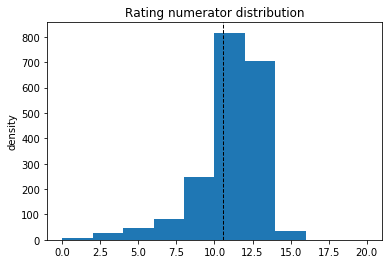

In [140]:
# plot the distribution of rating numerator
import seaborn as sns

plt.hist(tweet_all.rating_numerator,range=[0,20])
plt.title('Rating numerator distribution')
plt.ylabel('density')
plt.axvline(tweet_all.rating_numerator.mean(), color='k', linestyle='dashed', linewidth=1)

In [141]:
tweet_all.rating_numerator.describe()

count    1967.000000
mean     10.547422  
std      2.181847   
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      14.000000  
Name: rating_numerator, dtype: float64

#### summary:
The average rating is 10.55 which is above the rating renominator. In fact, more than 75% of the dogs were rated above 10. 

### 2. Plot the moving average of rating numerator to see if there is an overall change over time?

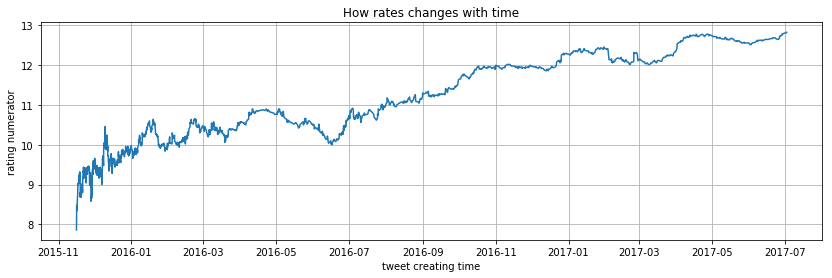

In [142]:
# calculate the moving average for every 50 rates
rate_smooth = tweet_all.rating_numerator.rolling(window=50).mean()

# plot the moving average rate with time
plt.figure(figsize=(14, 4))
plt.plot(tweet_all.timestamp,rate_smooth)
plt.title('How rates changes with time')
plt.xlabel('tweet creating time')
plt.ylabel('rating numerator')
plt.grid(axis='both')

#### summary:
The rating numerator gradually increased with time. 

### 3. How retweet count correlates to favorite count? do they also correlate with dog rating?

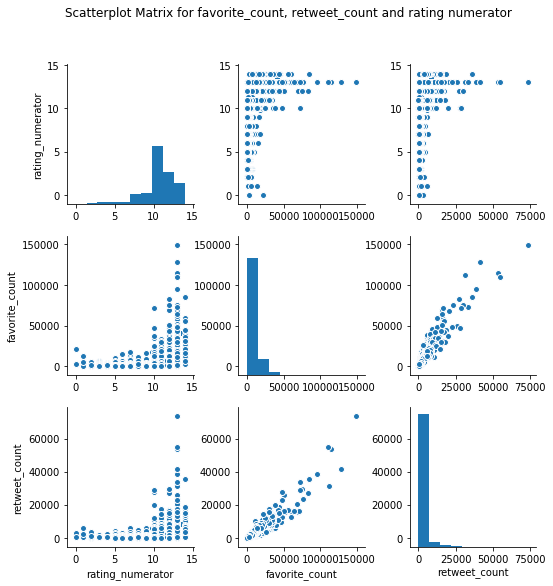

In [144]:
# make pair plot for favorite_count, retweet_count and rating numerator
df = tweet_all[['rating_numerator','favorite_count','retweet_count']]
g = sns.pairplot(df)
title = 'Scatterplot Matrix for favorite_count, retweet_count and rating numerator'
g.fig.suptitle(title, y=1.08)
plt.show()

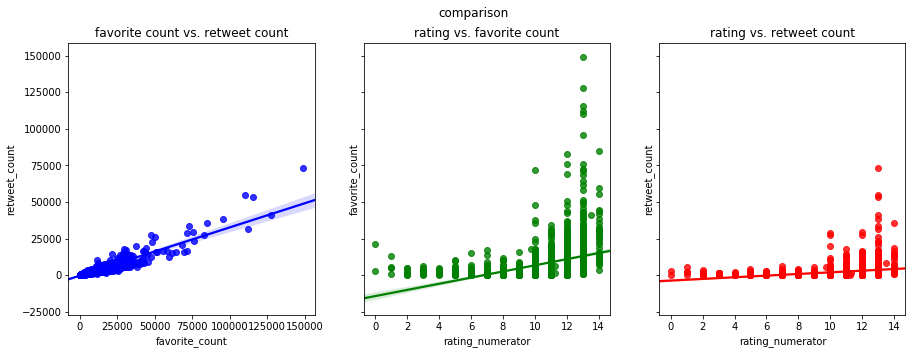

In [145]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('comparison')

sns.regplot(x=df.favorite_count, y=df.retweet_count, color="b",ax=axes[0])
axes[0].set_title('favorite count vs. retweet count')

sns.regplot(x=df.rating_numerator, y=df.favorite_count, color="g",ax=axes[1])
axes[1].set_title('rating vs. favorite count')

sns.regplot(x=df.rating_numerator, y=df.retweet_count, color="r",ax=axes[2])
axes[2].set_title('rating vs. retweet count')

plt.show()

#### summary:
From the figures, we observe that the favorite count is positively correlated with retweet count. Tweets with high favorite count are more frequently been retweeted. 
Tweets with higher rating also get more favorite and retweet count. 

### 4. Based on the image prediction, does certain dog breeds have relative higher rates than the others?

In [146]:
tweet_all.p1.value_counts()

golden_retriever             135
Labrador_retriever           90 
Pembroke                     88 
Chihuahua                    79 
pug                          54 
chow                         41 
Samoyed                      39 
Pomeranian                   38 
toy_poodle                   37 
malamute                     29 
cocker_spaniel               27 
French_bulldog               25 
Chesapeake_Bay_retriever     23 
miniature_pinscher           22 
seat_belt                    21 
German_shepherd              20 
Siberian_husky               19 
Staffordshire_bullterrier    18 
Eskimo_dog                   18 
Shetland_sheepdog            18 
Rottweiler                   17 
Shih-Tzu                     17 
Cardigan                     17 
teddy                        17 
beagle                       17 
Maltese_dog                  17 
Italian_greyhound            16 
Lakeland_terrier             16 
kuvasz                       16 
web_site                     15 
          

Compare rating for dog breeds with more than 50 counts, which are:

golden_retriever, Labrador_retriever, Pembroke ,Chihuahua, pug. 

In [147]:
dog_breeds = ['golden_retriever', 'Labrador_retriever', 'Pembroke' ,'Chihuahua', 'pug']
df = tweet_all[tweet_all['p1'].isin(dog_breeds)]

In [148]:
df.groupby('p1').rating_numerator.describe()

,count,mean,std,min,25%,50%,75%,max
p1,,,,,,,,
Chihuahua,79.0,10.708861,1.975179,3.0,10.00,11.0,12.0,14.0
Labrador_retriever,90.0,11.088889,1.329395,7.0,10.00,11.0,12.0,13.0
Pembroke,88.0,11.443182,1.721119,4.0,11.00,12.0,12.0,14.0
golden_retriever,135.0,11.625926,1.195012,8.0,11.00,12.0,12.0,14.0
pug,54.0,10.240741,1.912572,3.0,9.25,10.0,11.0,13.0


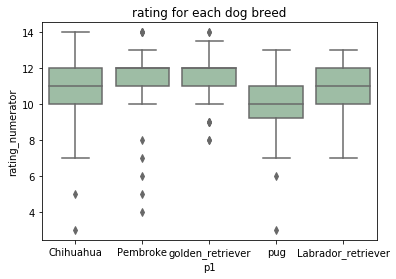

In [149]:
sns.boxplot(x='p1', y='rating_numerator', data=df,color='#99c2a2')
plt.title('rating for each dog breed')
plt.show()

In [150]:
# run anova analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('rating_numerator ~ C(p1)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,sum_sq,df,F,PR(>F)
C(p1),98.495968,4.0,9.831421,1.259000e-07
Residual,1104.538225,441.0,NaN,NaN


In [151]:
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

mcDate = multi.MultiComparison(df['rating_numerator'],df['p1'])
Results = mcDate.tukeyhsd()
print(Results)

          Multiple Comparison of Means - Tukey HSD,FWER=0.05         
      group1             group2       meandiff  lower   upper  reject
---------------------------------------------------------------------
    Chihuahua      Labrador_retriever   0.38   -0.2883  1.0484 False 
    Chihuahua           Pembroke       0.7343   0.0625  1.4062  True 
    Chihuahua       golden_retriever   0.9171   0.303   1.5311  True 
    Chihuahua             pug         -0.4681  -1.2335  0.2973 False 
Labrador_retriever      Pembroke       0.3543  -0.2956  1.0042 False 
Labrador_retriever  golden_retriever   0.537   -0.0529  1.1269 False 
Labrador_retriever        pug         -0.8481  -1.5943  -0.102  True 
     Pembroke       golden_retriever   0.1827  -0.4112  0.7767 False 
     Pembroke             pug         -1.2024  -1.9518 -0.4531  True 
 golden_retriever         pug         -1.3852  -2.0832 -0.6872  True 
---------------------------------------------------------------------


#### summary:
A one-way ANOVA indicates a significant effect of dog breeds on rating.

A post-hoc evaluation indicates Chihuahua got significant less rating than Labrador retriever but more rating than pug. Labrador retriever got significant less rating than Pembroke and golden retriever. Pembroke got significant less rating than golden retriever.